<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🪐Venus vs Mars</font>](https://www.kaggle.com/competitions/25mar24jh-venus-vs-mars-jhu/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [1]:
#from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

ModuleNotFoundError: No module named 'google.colab'

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle >> log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 25mar24jh-venus-vs-mars-jhu # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

Traceback (most recent call last):
  File "/bin/pip", line 6, in <module>
    from pkg_resources import load_entry_point
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 3254, in <module>
    def _initialize_master_working_set():
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 3237, in _call_aside
    f(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 3266, in _initialize_master_working_set
    working_set = WorkingSet._build_master()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 584, in _build_master
    ws.require(__requires__)
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 901, in require
    needed = self.resolve(parse_requirements(requirements))
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 787, in resolve
    raise DistributionNotFound(req, requirers)
pkg_resources.DistributionNotFound: The 'pip==20.0.2' distribution w

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [1]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
NVIDIA GeForce GTX 1080 Ti, 11264 MiB, 140 MiB, 10967 MiB


In [1]:
%%time
%%capture
%reset -f
!pip install -U tfds-nightly tensorflow_addons tensorflow keras plotly >> log  # update tfa in case students need to use it
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.applications import resnet50, xception, mobilenet, mobilenet_v2, mobilenet_v3
from tensorflow.keras.utils import image_dataset_from_directory as idfd
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'

2024-04-07 11:36:36.677289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 11:36:36.677408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 11:36:36.778470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-07 11:36:36.979907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 11:36:39.033873: W tensorflow/compiler/tf2

CPU times: user 3.55 s, sys: 2.07 s, total: 5.62 s
Wall time: 9.4 s


Examples of images from female class

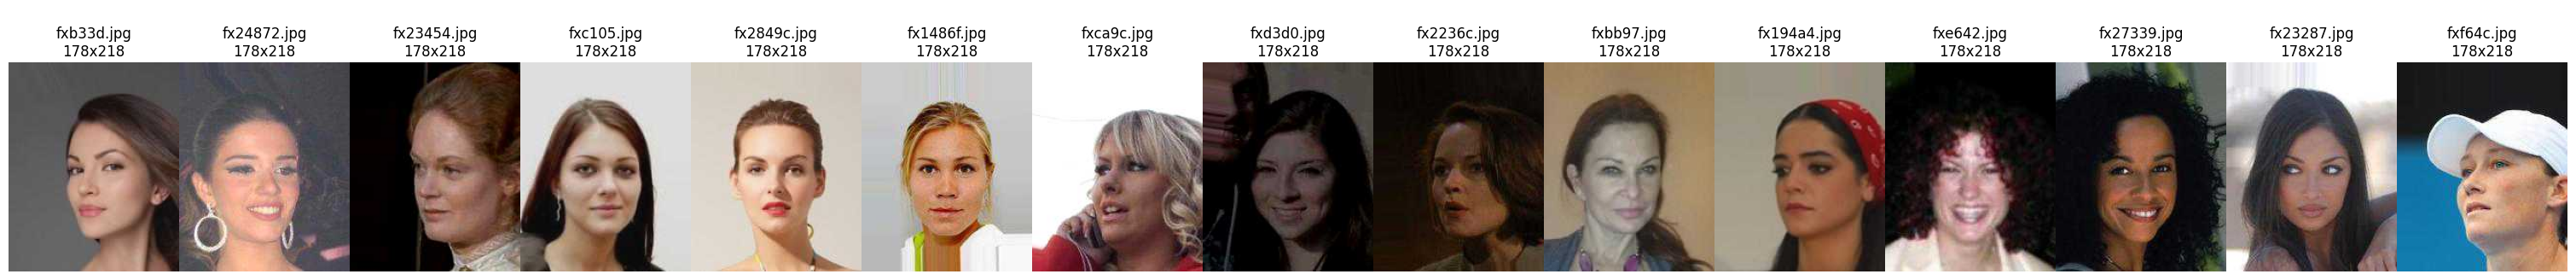

In [5]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = keras.preprocessing.image.load_img(tDIR+'female/'+f);
  _ = ax.set_title(f'\n{f}\n{img.size[0]}x{img.size[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

Examples of images from male class

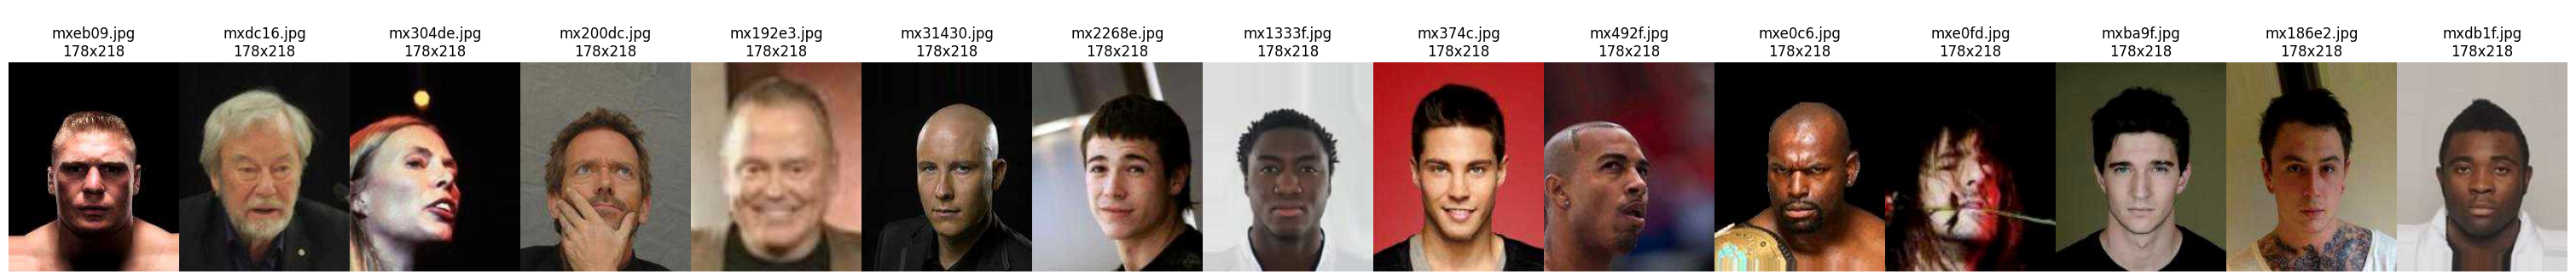

In [6]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = keras.preprocessing.image.load_img(tDIR+'male/'+f);
  _ = ax.set_title(f'\n{f}\n{img.size[0]}x{img.size[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [7]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

In [2]:
from keras.layers import BatchNormalization, Concatenate
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications import resnet50, resnet_v2

<font color=green><h3><b>$\alpha$. Load train, validation and test image sets</b><h3>

The following cell loads train/validation/test sets as [TF datasets](https://www.tensorflow.org/datasets), `tDS`, `vDS` and `sDS`, respectively.

In [11]:
BS, image_size = 64, (224, 224)  # batch size; image dimensions required by pretrained model
# Define preprocessing function using ResNet50 preprocessing
def preprocess_fn(image, label):
    # Reshape image to match ResNet50 input shape
    image = tf.image.resize_with_pad(image, 224, 224)
    # Apply ResNet50 preprocessing
    image = preprocess_input(image)
    return image, label

def preprocess_fn_test(image):
    # Reshape image to match ResNet50 input shape
    image = tf.image.resize_with_pad(image, 224, 224)
    # Apply ResNet50 preprocessing
    image = preprocess_input(image)
    return image

tDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='training', validation_split=0.2,
           class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=True, seed=0).map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)  # training dataset
vDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='validation', validation_split=0.2,
           class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=True, seed=0).map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)  # validation dataset
sDS = idfd( sDIR, labels=None, label_mode='binary', subset=None, validation_split=None,
           class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=False, seed=0)
vIDs = [f.split('/')[1].split('.')[0] for f in sDS.file_paths]   # parse image IDs from file names
sDS = sDS.map(preprocess_fn_test, num_parallel_calls=tf.data.AUTOTUNE)
print(tf.reduce_sum([tf.reduce_sum(f) for f in list(tDS.take(1))[0][0][:10]])) # to validate seeding of file sampling

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 5000 files belonging to 1 classes.
tf.Tensor(-405170.56, shape=(), dtype=float32)


<font color=green><h3><b>$\beta$. Load a pretrained model and set trainable layers.</b><h3>

<font color=green>This is your baseline DNN model. Remember to [seed all your experiments](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) for reproducibility. [Status of GPU-Determinism in TF](https://github.com/NVIDIA/framework-determinism/blob/master/tensorflow_status.md).

In [33]:
%%time
tf.random.set_seed(0)   # always seed your experiments
Init = keras.initializers.RandomNormal(seed=0) # seed all that you can

pm = resnet_v2.ResNet50V2(weights="imagenet", include_top=False, input_shape=[224,224,3])  # pretrained VGG16 model
conv = Dropout(0.1, seed=42)(pm.output)
avg = GlobalAveragePooling2D(data_format='channels_last')(conv)
conv = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer="he_normal", padding="same")(conv)
conv = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer="he_normal", padding="same")(conv)
conv = Dropout(0.1, seed=42)(conv)
conv = MaxPooling2D(5)(conv)
conv = Conv2D(filters=128, kernel_size=3, activation="relu", kernel_initializer="he_normal", padding="same")(conv)
#conv = MaxPooling2D(5)(conv)
conv = Dropout(0.2, seed=42)(conv)
conv = Flatten()(conv)
conv = Dense(128, activation="relu", kernel_initializer="he_normal")(conv)
conv = Dropout(0.4, seed=42)(conv)
conv = Dense(64, activation="relu", kernel_initializer="he_normal")(conv)
conv = Dropout(0.4, seed=42)(conv)
conv = Dense(32, activation="relu", kernel_initializer="he_normal")(conv)
conv = Dropout(0.4, seed=42)(conv)
concat = Concatenate()([conv, avg])
output = Dense(1, activation="sigmoid", kernel_initializer="glorot_normal")(concat)
pm1 = keras.Model(inputs=pm.input, outputs=output)
for l in pm.layers: l.trainable = False                                # freeze layers from training
pm1.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

<font color=green><h3><b>$\gamma$. Configure and train new layers.</b><h3>

<font color=green>Below we replace the top layer of the pretrained CNN ([MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)) and train the new layer only (all remaining pretrained layers are frozen).

In [34]:
with tf.device('/GPU:0'):
    #lrs = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.02, decay_steps=100, decay_rate=0.1)
    opt = keras.optimizers.Adam(learning_rate=0.0012)
    #opt = keras.optimizers.SGD(learning_rate=lrs, momentum=0.5)
    pm1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    hist = pm1.fit(tDS, epochs=2, validation_data=vDS)     # For BS=32, 2xCPU: 15min/epoch, GPU: 15sec/epoch  (60x faster)


Epoch 1/2


2024-04-07 12:13:08.317537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 [==============================] - 19s 208ms/step - loss: 0.4122 - accuracy: 0.8075 - val_loss: 0.3010 - val_accuracy: 0.8770
Epoch 2/2
63/63 [==============================] - 12s 188ms/step - loss: 0.2533 - accuracy: 0.8992 - val_loss: 0.2489 - val_accuracy: 0.9000


<font color=green><h3><b>$\delta$. Configure and post-train unlocked pre-trained layers.</b><h3>

In [35]:
%%time
with tf.device('/GPU:0'):
    for l in pm.layers: l.trainable = True      # allow training
    opt = keras.optimizers.Adam(learning_rate=0.00012)
    pm1.compile(loss="binary_crossentropy", optimizer=opt, metrics=['binary_accuracy'])
    hist = pm1.fit(tDS, epochs=3, validation_data=vDS)

Epoch 1/3


63/63 [==============================] - 59s 501ms/step - loss: 0.2120 - binary_accuracy: 0.9122 - val_loss: 0.4927 - val_binary_accuracy: 0.8840
Epoch 2/3
63/63 [==============================] - 31s 485ms/step - loss: 0.0330 - binary_accuracy: 0.9885 - val_loss: 0.2604 - val_binary_accuracy: 0.9460
Epoch 3/3
63/63 [==============================] - 31s 480ms/step - loss: 0.0058 - binary_accuracy: 0.9987 - val_loss: 0.2455 - val_binary_accuracy: 0.9510
CPU times: user 1min 59s, sys: 25.2 s, total: 2min 24s
Wall time: 2min 1s


<font color=green><h3><b>$\epsilon$. Make predictions.</b><h3>

In [10]:
#vIDs = [f.split('/')[1].split('.')[0] for f in sDS.file_paths]   # parse image IDs from file names
pY = pd.DataFrame(pm1.predict(sDS), index=vIDs, columns=['y'])   # predicted targets
ToCSV((pY>0.5)*1, 'resnet-w-and-d-prep-tuned')

79/79 [==============================] - 11s 131ms/step


<font color=green><h3><b>$\zeta$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

<font color=green><h3><b>$\eta$. References</b></h3></font>

<font color=red><b>Your answer here.</b></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, HOML textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

1. ...
1. ...

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

## 💡**Starter Ideas**

1. Try tuning CNN hyperparameters and architecture
1. Other [pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) can be faster or more accurate for the given dataset and/or hardware ([benchmarks](https://datascience.stackexchange.com/a/39211/14094))
1. Transforming images via [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)could be faster
1. Identify poorly predicted train images (with near-boundary confidence) and add their augmented versions
1. Identify poorly predicted test images (with near-boundary confidence) and post-train CNN even more on "similar" train images. Similarity can be done in terms of some of the layer(s) of CNN
1. Do you really need all given images? CNN will train faster on a "meaningful" subsample
1. Try ensembling different pretrained CNNs or only their selected layers
1. Try different learning rate for different layers of pretrained models
1. Try cropping instead of resizing images to the fixed $224\times224$ (faces look more naturally if aspect ratio is respected)
1. Try [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) in Colab. 😮 See [doc example](https://www.tensorflow.org/guide/tpu). Local images should be loaded with [Python I/O](https://stackoverflow.com/a/63147614/3043335), not TF datasets.